Implement a basic GAN to generate handwritten digits.
Train on MNIST dataset.
Compare generated and real samples.

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


Epoch [1/50]  Loss_D: 0.9658  Loss_G: 0.9982
Epoch [2/50]  Loss_D: 1.1934  Loss_G: 0.8137
Epoch [3/50]  Loss_D: 1.0915  Loss_G: 0.8745
Epoch [4/50]  Loss_D: 0.9998  Loss_G: 0.9947
Epoch [5/50]  Loss_D: 0.9000  Loss_G: 1.2915
Epoch [6/50]  Loss_D: 0.8432  Loss_G: 1.2106
Epoch [7/50]  Loss_D: 1.1990  Loss_G: 0.9194
Epoch [8/50]  Loss_D: 1.3579  Loss_G: 0.9931
Epoch [9/50]  Loss_D: 1.5446  Loss_G: 0.7199
Epoch [10/50]  Loss_D: 0.8591  Loss_G: 1.2681
Epoch [11/50]  Loss_D: 1.1181  Loss_G: 0.9291
Epoch [12/50]  Loss_D: 0.7715  Loss_G: 1.3030
Epoch [13/50]  Loss_D: 0.6106  Loss_G: 1.7820
Epoch [14/50]  Loss_D: 0.8443  Loss_G: 1.5127
Epoch [15/50]  Loss_D: 0.7009  Loss_G: 1.2829
Epoch [16/50]  Loss_D: 0.7041  Loss_G: 1.4867
Epoch [17/50]  Loss_D: 0.6050  Loss_G: 1.8791
Epoch [18/50]  Loss_D: 0.2952  Loss_G: 2.3519
Epoch [19/50]  Loss_D: 0.3549  Loss_G: 2.7102
Epoch [20/50]  Loss_D: 0.7013  Loss_G: 2.1990
Epoch [21/50]  Loss_D: 0.2282  Loss_G: 2.5232
Epoch [22/50]  Loss_D: 0.4892  Loss_G: 2.25

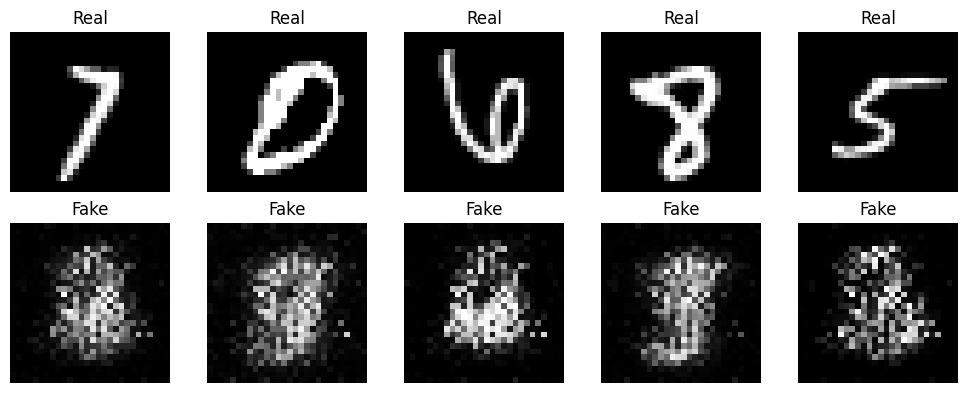

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


latent_dim = 100
batch_size = 128
lr = 0.0002
num_epochs = 50


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


G = Generator().to(device)
D = Discriminator().to(device)


criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=lr)
opt_D = torch.optim.Adam(D.parameters(), lr=lr)


for epoch in range(num_epochs):
    for imgs, _ in loader:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)


        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        D_real = D(imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = criterion(D_real, real) + criterion(D_fake, fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()


        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        D_output = D(fake_imgs)
        loss_G = criterion(D_output, real)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")


def show_images(real, fake, num=5):
    real = real[:num].cpu().detach()
    fake = fake[:num].cpu().detach()
    fig, axs = plt.subplots(2, num, figsize=(num * 2, 4))
    for i in range(num):
        axs[0, i].imshow(real[i].squeeze(), cmap='gray')
        axs[0, i].axis("off")
        axs[0, i].set_title("Real")
        axs[1, i].imshow(fake[i].squeeze(), cmap='gray')
        axs[1, i].axis("off")
        axs[1, i].set_title("Fake")
    plt.tight_layout()
    plt.show()


z = torch.randn(5, latent_dim).to(device)
generated_imgs = G(z)
real_imgs, _ = next(iter(loader))
show_images(real_imgs, generated_imgs)
